# Forecast Window 

We put our trained models to the test by asking it to predict the trend of $C_n^{2}$ over the course of an entire month. 

In [8]:
# Loading some useful packages

import tensorflow as tf 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from scipy import stats

import os

Useful functions used for the preparation of data 

In [26]:
# Batches consecutive data i.e. data w/o temporal jumps 
# direc_name - String - name of data directory 
# iterate - int - difference between data names to consider data being 'consecutive'

def batch_consecutive(direc_name, iterate=1):
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    prev_int = int(os.path.splitext(directory_list[0])[0])
    total_batches = []
    consecutive_batch = []
    
    for jj, name in enumerate(directory_list):
        name_int = int(os.path.splitext(name)[0])
        if (name_int-prev_int==iterate) or (name_int-prev_int==0):
            consecutive_batch.append(name)
            prev_int = name_int

        elif(name_int-prev_int>iterate):
            total_batches.append(consecutive_batch)
            consecutive_batch = []
            consecutive_batch.append(name)
            prev_int = name_int
        
    total_batches.append(consecutive_batch)
    return total_batches


# This normalizes the data given that the normalization is determined externally w/ the above routine and e.g. using another dataset. 
# x -- list -- column to be normalized 
# minX - double -- minimum reported value of x. This is calculated externally 
# maxX - double -- maximum reported value of x. This is calculated externally

def norm_data_select(x, minX, maxX):  
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Reads hour entries in the .csv files and converts to pythonic integer.
# This is specific to the format of our data

def hours_to_int(x):
    if x[0:-2]=='':
        return 0
    else:
        return int(x[0:-2])
    
# Converts time in a hour:minute format into seconds
# hour - int - hours from 0 to 23
# minute - int - minutes from 0 to 59

def convert_to_sec(minute, hour):
    return 3600*hour + 60*minute

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 
# x - one-dim array - input column 
# minX - double - minimum value. Calculated externally. 
# maxX - double - maximum value. Calculated externally. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    print(unnorm_fac)
    return x*unnorm_fac + minX

# Slight modification of the existing MSE metric used to evalutate the model training performance. 
# y_true - Tensorflow Tensor - actual time series 
# y_pred - Tensorflow Tensor - predicted time series. 
    
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8


# Loads data in preparation for training. 
#
# total_batches -- array -- batched data 
# direc_name -- string -- name of directory folder where data is located
# time_steps -- int -- number of INPUT time steps
# input_list -- list (of strings) -- names of input features
# num_examples -- int -- maximum number of examples to load
# full_time_series -- boolean -- do we output the full time series or just the last time step. 
# forecast_len -- int -- by how much ahead are we making the forecast 
# time_res -- int -- time resolution of output steps 
# start_index -- int -- index for which we start the training

def load_data(total_batches, direc_name, time_steps, input_list, num_of_examples, full_time_series=False,  forecast_len=1, time_res=1, start_index=0):
    
    total_input = []
    total_output = []
    
    # Files expected
    
    num_features = len(input_list)
    print(num_features)
    if ('day' in input_list):
        num_features+= 1
    if ('time' in input_list):
        num_features+= 1
    
    print(f'Parameter List: {input_list}')
    print(f'Number of Examples: {num_of_examples}')
    
    num_of_zeros = 0
    
    for jj, name in enumerate(total_batches, start=start_index):

        if (jj>num_of_examples):
            print("Finished loading data!")
            break;
        
        df = pd.read_csv(f'{direc_name}/{name}')
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation', 'Wind Speed m/s':'wind_speed', 'SOG cm':'SOG','Pressure hPa':'pressure', 'hr:min (UTC)':'time', 'Julian day (UTC)': 'day'})
        # Map the day into a unit circle, and create 'day_sin'  and 'day_cos' to define the x and y components in the circle. 
        df['day_sin'] = np.sin(df['day']*(2.*np.pi/365))
        df['day_cos'] = np.cos(df['day']*(2.*np.pi/365))
        # For time, we convert to string representation
        df['time']=df['time'].astype(str)
        df['minute'] = df['time'].apply(lambda x: int(x[-2:]))
        df['hour'] = df['time'].apply(lambda x: hours_to_int(x))
        df['second'] = convert_to_sec(df['minute'], df['hour'])
        # Map the time into a unit circle 
        df['time_sin']= np.sin(df['second']*(2.*np.pi/86400))
        df['time_cos']= np.cos(df['second']*(2.*np.pi/86400))
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
    
            num_of_zeros += 1
            print(f'number of zeros: {num_of_zeros}')
            print('error data detected. Skipping to next value')
            continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        ii= 0
        kk= 0 # index for column
        
        while ii < num_features:
           # print(ii)
            colName = input_list[kk]
            if(colName=='day'):
             
                # include both day_sin and day_cos
                
                dataset_weather[:,ii] = df['day_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['day_cos'].to_numpy()
                
            elif(colName=='time'):
                
                # Include both time_sin and time_cos
                
                dataset_weather[:,ii] = df['time_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['time_cos'].to_numpy()
               
                
            elif(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                
                dataset_weather[:,ii] = df[colName].to_numpy()
            kk += 1
            ii += 1
                
        ###### OUTPUT DATA #######
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    if(full_time_series):
        return total_input, total_output
    else:
        return total_input, total_output[:,0]

# Load Trained Model 

Load the trained model

In [32]:
current_model = 'model_noFebMar'

loaded_model = tf.keras.models.load_model(f'models/{current_model}', custom_objects={'mse_mod':mse_mod})

# Load The Data

In [33]:
# Indicate the input features to include for the model

input_features = ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']

number_of_features = len(input_features)
if ('day' in input_features):
    number_of_features+= 1
if ('time' in input_features):
    number_of_features+= 1

# Specify parameters for the input/output time series 

time_len = 720
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)

direc_name = f"Batched Data/FebMar_Unseen" # This is the part of the dataset not seen by the network 
direc_name_raw = f"Batched Data/FebMarch_Unseen_RAW" # Same as above but without applying the window averaging

# We batch the data up into consecutive periods. The start of the next batch indicates a discontinuity. 

total_batches = batch_consecutive(direc_name, 1)
total_batches_raw = batch_consecutive(direc_name_raw, 1)

Having batched the data, proceed to format the data batchwise

In [34]:
X = []
y = []
y_raw = []
X_raw = []
x_minor_ticks = [] 

count_init = 0
start_index = 0
end_index = 100

for ii in range(0, len(total_batches)):
    X_temp, y_temp = load_data(total_batches[ii], direc_name, time_len, input_features, end_index, full_time_series=True, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
    X_raw_temp, y_raw_temp = load_data(total_batches[ii], direc_name_raw, time_len, input_features, end_index, full_time_series=True, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
    
    temp = np.shape(y_temp.flatten())[0]/4
    
    # This helps to indicate when in the calender does each batch end. 
    
    count_init += int(temp)
    x_minor_ticks.append(count_init) 
    
    X.append(X_temp)
    y.append(y_temp)
    
    y_raw.append(y_raw_temp)
    X_raw.append(X_raw_temp)


5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
Data loaded:0
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 10

Concatenate the loaded batch data for the purposes of constructing the month-long time series prediction

In [35]:
X = np.concatenate(X)
y = np.concatenate(y)

X_raw = np.concatenate(X_raw)
y_raw = np.concatenate(y_raw)

Normalize the data according to the minimum/maximum of the training data. The network still processes predictions using the window averaged input data, but the model predictions will be compared to the raw, unfiltered values. 

In [36]:
# Minimum and maximum values for each input feature as computed on the training data. Note that time has two feature entries to reflect the sin and cos components. 

minTrain = [16.29781, -0.3995518, -18.04353,  -1.0, -1.0, -16.46344155742847]
maxTrain = [99.52488, 71.5599, 32.07004, 1.0, 1.0, -13.749579997691106]

for ii in np.arange(number_of_features):
        X[:,:,ii], _, _= norm_data_select(X[:,:,ii], minTrain[ii], maxTrain[ii])
        
        if (ii==number_of_features-1):
            y[:,:,0],_,_ = norm_data_select(y[:,:,0], minTrain[ii], maxTrain[ii])
            y_raw[:,:,0],_,_ = norm_data_select(y_raw[:,:,0], minTrain[ii], maxTrain[ii])

Compute predictions from each loaded time series to create a predicted 12 hour time series 

In [43]:
# Computes the root mean squared error between the true and predicted time series 
# y_true - actual time series
# y_pred - predicted time series

def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

total_forecasts = np.array([])
y_total = np.array([])
y_raw_total = np.array([])

for ii in range(len(y)):
    X_expand = tf.expand_dims(X[ii,:,:], axis=0)
    preds = loaded_model.predict(X_expand, verbose=False)
    preds = np.array(preds[0]).flatten()
    print(preds)
    
    total_forecasts = np.concatenate([total_forecasts, preds])
    y_total = np.concatenate((y_total, y[ii,:,0]))
    y_raw_total = np.concatenate((y_raw_total, y_raw[ii,:,0]))

[0.5427637  0.5601438  0.5818034  0.5928259  0.6011441  0.60548717
 0.5972525  0.5924152  0.58978426 0.59148914 0.5981966  0.6109078
 0.63602763 0.66165036 0.6951652  0.7305195  0.7653374  0.7960545
 0.82425505 0.8530871  0.8723331  0.89109117 0.9028873  0.9037799 ]
[0.9199978  0.92190063 0.92835623 0.9317808  0.9285842  0.92902017
 0.91444165 0.9138509  0.90387434 0.9093919  0.91628754 0.91355276
 0.9139462  0.90624195 0.91280854 0.90160996 0.8896518  0.88638157
 0.85327786 0.83751017 0.8025218  0.8027686  0.7643538  0.7365875 ]
[0.86635375 0.8831558  0.89047873 0.89513654 0.9051019  0.90656435
 0.9175909  0.9214605  0.9290679  0.93039894 0.9307858  0.93623614
 0.9314229  0.93167335 0.9220477  0.9168884  0.91189355 0.9029554
 0.888234   0.8802679  0.85438854 0.8359959  0.80843997 0.7826739 ]
[0.7461384  0.69556344 0.64500934 0.57666254 0.50809073 0.45846593
 0.4523339  0.4811694  0.5221462  0.56319594 0.58074456 0.57974887
 0.57352173 0.54721624 0.54597217 0.5330856  0.5288105  0.5257

[0.8581467  0.86398673 0.8414108  0.8316788  0.8241087  0.77627885
 0.7876873  0.7971114  0.7887284  0.7800357  0.78582793 0.77303827
 0.7720256  0.77831155 0.7563264  0.77042687 0.76432836 0.7405854
 0.74656755 0.72313744 0.736096   0.7547546  0.76633155 0.7470258 ]
[0.6272782  0.6462326  0.67289937 0.7230951  0.77930975 0.8265023
 0.84730303 0.86335474 0.8611068  0.8544619  0.8413842  0.83252823
 0.82548475 0.8062945  0.79875815 0.79658157 0.79630995 0.7826216
 0.7847408  0.7929961  0.79413277 0.78965807 0.79080147 0.8033372 ]
[0.7757717  0.7812271  0.81964004 0.849157   0.8715332  0.87202704
 0.86244136 0.8462204  0.8469903  0.83289546 0.8173178  0.779993
 0.72141933 0.6701834  0.6311119  0.6281835  0.6655812  0.69922405
 0.74783444 0.79109305 0.8351865  0.8588385  0.8735442  0.8817481 ]
[0.89457756 0.9041249  0.9109031  0.9008233  0.88340265 0.8495864
 0.7732594  0.7298566  0.70283693 0.69380665 0.71130097 0.72020304
 0.73194295 0.7352742  0.7345933  0.7277666  0.73165256 0.7078619

# Make the big crazy plot

2.7138615597373654
2.7138615597373654


C:\Users\freem\AppData\Local\Temp\ipykernel_16136\1736385182.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(hours[index_start:index_end], y_CN2[index_start:index_end], marker = 'd', facecolors='none', edgecolors=edgecolors[index_start:index_end], cmap='viridis_r', label='truth', s=36)


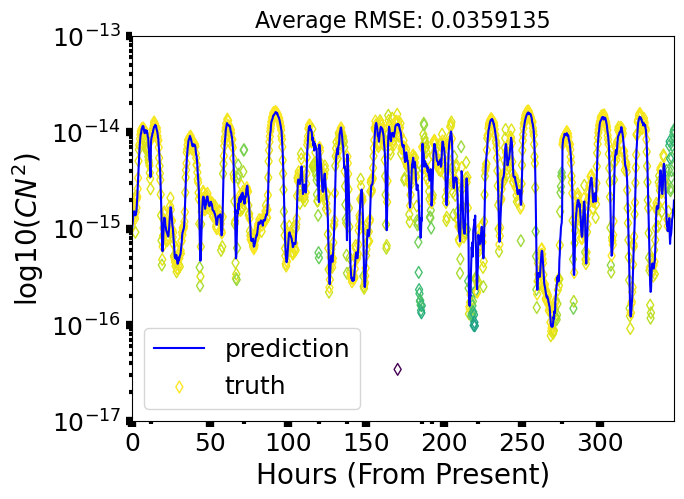

In [44]:
from matplotlib import cm

# Converts minutes to hour
# minute - int - number of minutes 
def min_to_hour(minute):
    return minute/60

fig_name = "prediction_febMar"

total_hours = len(total_forecasts)
hours = min_to_hour(np.arange(0,total_hours*15,15))

# Compute the RMS between predicted and the unfiltered y values. 

errors = rms(total_forecasts, y_raw_total)

y_CN2 = 10**(unnorm_data(y_raw_total, minTrain[-1], maxTrain[-1])) # Original data points
prediction = 10**(unnorm_data(total_forecasts, minTrain[-1], maxTrain[-1])) # predicted value.  

index_start = 0
index_end = -1


cmap = plt.get_cmap('viridis_r')
norm_edge = plt.Normalize(min(errors), max(errors))
edgecolors = cmap(norm_edge(errors))

plt.figure(figsize=(7,5))

plt.plot(hours[index_start:index_end], prediction[index_start:index_end], color='blue', label = 'prediction')
plt.scatter(hours[index_start:index_end], y_CN2[index_start:index_end], marker = 'd', facecolors='none', edgecolors=edgecolors[index_start:index_end], cmap='viridis_r', label='truth', s=36)

plt.ylabel(r'log10($CN^2$)', fontsize='20')
plt.xlabel('Hours (From Present)', fontsize='20')
plt.xticks(fontsize='18')
plt.xticks(x_minor_ticks, minor=True)
plt.yticks(fontsize='18')
plt.ylim(10**-17, 10**-13)
plt.xlim(-0.25+np.min(hours[index_start:index_end]),np.max(hours[index_start:index_end])+0.25)
plt.tick_params(which='major', width=6, length=4)
plt.tick_params(which='minor', width=3, length=2)
plt.yscale('log')
plt.title(f'Average RMSE: {round(np.mean(errors[index_start:index_end]),7)}', fontsize='16')

plt.legend(fontsize='18')

Save the figure. 

In [ ]:
plt.savefig(f'{fig_name}.pdf', format='pdf', bbox_inches='tight')